# Set up

In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


In [2]:
train_path = 'C:/Data_floods/Train'
valid_path = 'C:/Data_floods/Valid'
test_path = 'C:/Data_floods/Test'

In [3]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['Floods', 'Not Floods'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['Floods', 'Not Floods'], batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['Floods', 'Not Floods'], batch_size=10)

Found 200 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [5]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [6]:
imgs, labels = next(train_batches)

C:\Users\samar\Anaconda3\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


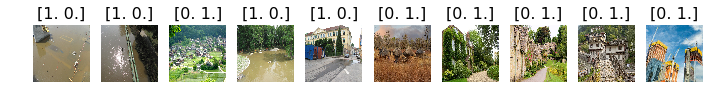

In [7]:
plots(imgs, titles=labels)

# Build and train CNN

In [8]:
model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
        Flatten(),
        Dense(2, activation='softmax'),
    ])

In [9]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1577088)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3154178   
Total params: 3,155,074
Trainable params: 3,155,074
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit_generator(train_batches, steps_per_epoch=4, 
                    validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
 - 3s - loss: 8.4329 - acc: 0.4500 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/5
 - 3s - loss: 8.4620 - acc: 0.4750 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/5
 - 2s - loss: 6.4472 - acc: 0.6000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/5
 - 2s - loss: 8.8650 - acc: 0.4500 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/5
 - 2s - loss: 9.2679 - acc: 0.4250 - val_loss: 8.0590 - val_acc: 0.5000


# Predict

C:\Users\samar\Anaconda3\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


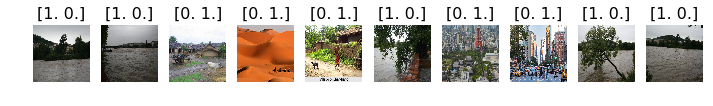

In [12]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [13]:
test_labels = test_labels[:,0]
test_labels

array([1., 1., 0., 0., 0., 1., 0., 0., 1., 1.], dtype=float32)

In [14]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)
len(predictions)

10

In [15]:
for i in range(len(predictions)):
    if predictions[i][0]<0.5:
        predictions[i]=[0.,1.]
    else:
        predictions[i]=[1.,0.]
predictions

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [16]:
cm = confusion_matrix(test_labels, predictions[:,0])

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[0 5]
 [0 5]]


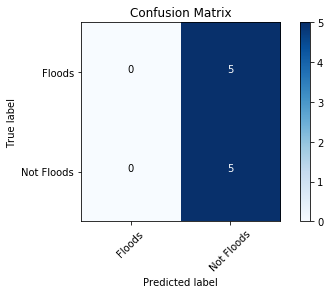

In [18]:
cm_plot_labels = ['Floods','Not Floods']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## Build Fine-tuned VGG16 model

In [19]:
vgg16_model = keras.applications.vgg16.VGG16()

C:\Users\samar\Anaconda3\lib\site-packages\keras\utils\conv_utils.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


In [20]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [21]:
type(vgg16_model)

keras.engine.training.Model

In [22]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [24]:
model.layers.pop()

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [26]:
for layer in model.layers:
    layer.trainable = False

In [27]:
model.add(Dense(2, activation='softmax'))

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

## Train the fine-tuned VGG16 model

In [29]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.fit_generator(train_batches, steps_per_epoch=4, 
                    validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
 - 21s - loss: 0.6919 - acc: 0.6750 - val_loss: 0.6907 - val_acc: 0.5000
Epoch 2/5
 - 26s - loss: 0.6920 - acc: 0.6250 - val_loss: 0.6907 - val_acc: 0.5000
Epoch 3/5
 - 22s - loss: 0.6931 - acc: 0.5750 - val_loss: 0.6906 - val_acc: 0.5000
Epoch 4/5
 - 20s - loss: 0.6925 - acc: 0.5000 - val_loss: 0.6905 - val_acc: 0.5000
Epoch 5/5
 - 23s - loss: 0.6919 - acc: 0.5500 - val_loss: 0.6905 - val_acc: 0.5000


In [31]:
#old model results
#model.fit_generator(train_batches, steps_per_epoch=4, 
#                    validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

If saving this model with model.save('file.h5'), note that some users have reported the following error when loading the model using load_model('file.h5'):
    
ValueError: Dimension 0 in both shapes must be equal, but are 4096 and 1000.
Shapes are [4096,10] and [1000,10]. for 'Assign_61' (op: 'Assign') with input shapes: [4096,10], [1000,10].
   
If you receive this error, please see the answer in this stackoverflow post:
https://stackoverflow.com/questions/48482483/valueerror-when-loading-a-previously-saved-retrained-vgg16-model-using-keras

## Predict using fine-tuned VGG16 model

C:\Users\samar\Anaconda3\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


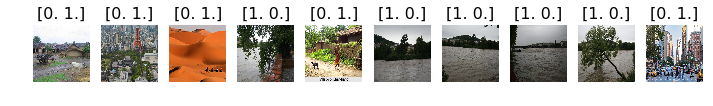

In [32]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [33]:
test_labels = test_labels[:,0]
test_labels

array([0., 0., 0., 1., 0., 1., 1., 1., 1., 0.], dtype=float32)

In [34]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [35]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

Confusion matrix, without normalization
[[3 2]
 [1 4]]


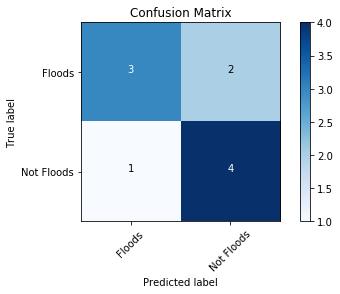

In [36]:
cm_plot_labels = ['Floods','Not Floods']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [2]:
#Trying to implement FCS-32 model
from keras.applications.vgg16 import *
from keras.models import *
from keras.applications.imagenet_utils import _obtain_input_shape
import keras.backend as K
import tensorflow as tf

from utils.get_weights_path import *
from utils.basics import *
from utils.resnet_helpers import *
from utils.BilinearUpSampling import *

Using Theano backend.


ImportError: cannot import name '_obtain_input_shape'

In [3]:
def FCN_Vgg16_32s(input_shape=None, weight_decay=0., batch_momentum=0.9, batch_shape=None, classes=21):
    if batch_shape:
        img_input = Input(batch_shape=batch_shape)
        image_size = batch_shape[1:3]
    else:
        img_input = Input(shape=input_shape)
        image_size = input_shape[0:2]
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', kernel_regularizer=l2(weight_decay))(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Convolutional layers transfered from fully-connected layers
    x = Conv2D(4096, (7, 7), activation='relu', padding='same', name='fc1', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same', name='fc2', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    #classifying layer
    x = Conv2D(classes, (1, 1), kernel_initializer='he_normal', activation='linear', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)

    x = BilinearUpSampling2D(size=(32, 32))(x)

    model = Model(img_input, x)

    weights_path = os.path.expanduser(os.path.join('~', '.keras/models/fcn_vgg16_weights_tf_dim_ordering_tf_kernels.h5'))
    model.load_weights(weights_path, by_name=True)
    return model
